## Text classification on LeMonde2003 Dataset

In this notebook, we 
apply classification algorithms to newspaper articles published in 2003 in *Le Monde*. 

The data are here : https://cloud.teklia.com/index.php/s/isNwnwA7a7AWst6/download/LeMonde2003_9classes.csv.gz

Download it into the data directory : 

```
wget https://cloud.teklia.com/index.php/s/isNwnwA7a7AWst6/download/LeMonde2003_9classes.csv.gz
```

Or you can download the file directly from the URL in pandas with `pd.read_csv(url)`.`

These articles concern different subjects but we will consider only articles related to the following subjects : entreprises (ENT), international (INT), arts (ART), société (SOC), France (FRA), sports (SPO), livres (LIV), télévision (TEL) and the font page articles (UNE).


> * Load the CSV file `LeMonde2003_9classes.csv.gz` containing the articles using pandas [pd.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html). How many articles do you have ? 
> * Plot the frequency histogram of the categories using seaborn [countplot](https://seaborn.pydata.org/tutorial/categorical.html) : `sns.countplot(data=data,y='category')`
> * Display the text of some of the article with the corresponding class using pandas [sample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html)
> * Using the [WordCloud library](https://amueller.github.io/word_cloud/index.html), display a word cloud for the most frequent classes. You can remove the stop words using the `stopwords` option, using the list of stop words in French in `data/stop_word_fr.txt` or from the URL https://cloud.teklia.com/index.php/s/3mwZfSre4PmJcdb/download/stop_word_fr.txt



In [51]:
# Imports
#!pip install wordcloud
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

In [5]:
data = pd.read_csv('https://cloud.teklia.com/index.php/s/isNwnwA7a7AWst6/download/LeMonde2003_9classes.csv.gz')
data.head()

,text,category
0,a la boutique du fulham fc nichée au dernier é...,SPO
1,pour la plupart de ceux qui n'y vivent pas la ...,ART
2,la perspective d'une enquête judiciaire sur la...,FRA
3,le tribunal administratif de limoges a annulé ...,SOC
4,des avions américains et britanniques ont bomb...,INT


In [6]:
data.shape[0]
# there are 30,165 articles

30165

Text(0.5, 1.0, 'Distribution of categories')

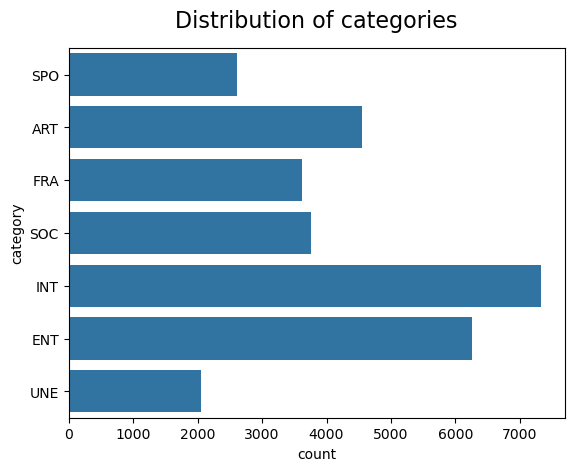

In [18]:
# Distribution of categories
sns.countplot(data = data, y='category').set_title("Distribution of categories", fontsize=16, pad=15)

count     30165
unique        7
top         INT
freq       7328
Name: category, dtype: object


Text(0, 0.5, 'Frequency')

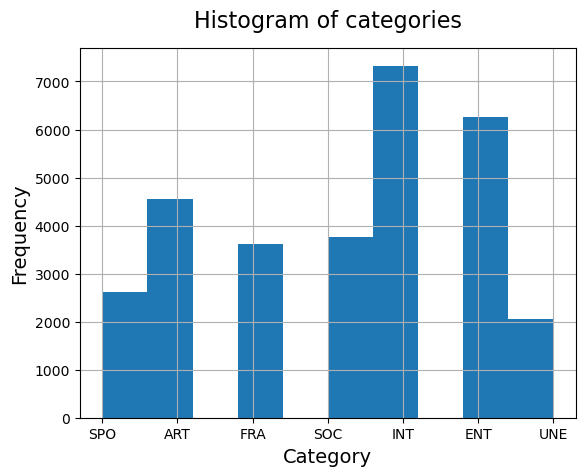

In [27]:
# Histogram
print(data['category'].describe())
data['category'].hist()
plt.title("Histogram of categories", fontsize=16, pad=15)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

In [28]:
# Printing examples of the articles
pd.set_option('display.max_colwidth', None)
data.sample(4)

,text,category
19612,une vingtaine de wagons de marchandise dûment assemblés et plombés attendent depuis plusieurs jours dans la gare d'abidjan c'est le train de l'espoir s'il part comme prévu ce vendredi 19 septembre premier anniversaire de l'insurrection du nord il symbolisera non seulement un début de réunification de la côte d'ivoire mais aussi la fin d'une guerre non déclarée avec le burkina faso le voisin sahélien d'où la rébellion est partie 1 154 km séparent abidjan et ouagadougou avant le 19 septembre 2002 il fallait une trentaine d'heures pour les parcourir dont quatre à cinq de harcèlement douanier à la frontière celle-ci a été rouverte il y a neuf jours mais aujourd'hui l'espoir n'est pas sûr d'arriver à destination d'abord parce que la côte d'ivoire est toujours divisée elle est coupée en deux une moitié nord faiblement peuplée sous contrôle rebelle et la partie gouvernementale du sud le pays utile en fait elle est même démembrée en trois zones puisque les insurgés se subdivisent en factions celle plus politique de guillaume soro dont le fief est bouaké au centre et celle d ' i.b le sergent-chef ibrahim coulibaly qui vient d'être remis en liberté conditionnelle par la justice française mais reste inculpé d'un coup de force qu'il aurait préparé depuis paris jusqu'au 16 août installé à ouagadougou il commande les rebelles les plus intransigeants dont le fief est korhogo dans l'extrême nord tous les opérateurs économiques sont unanimes s'il est toujours difficile de travailler en zone rebelle celle d ' ib est la plus chaotique pressions françaises néanmoins depuis plusieurs mois des activités économiques ont repris entre le nord et le sud ainsi depuis le 22 mai les trains de sitarail la compagnie ferroviaire ivoiro-burkinabé dont le groupe français bolloré est le principal actionnaire montent de l'engrais et descendent du coton graine un service minimal qui s'est heurté à de vives résistances au sud les patriotes qui suspectaient le train de rouler pour les rebelles ont à plusieurs reprises démonté les rails pour empêcher des infiltrations au nord les rebelles ont réclamé leurs dîmes s'ils n'ont pas préféré vendre le coton en contrebande dans les pays voisins les accords conclus avec leur état-major n'ont pas empêché les exactions c'est le terrain qui commande résume un cheminot que voulez-vous faire quand un type armé se plante devant vous ensuite il y a le problème de la frontière internationale elle a été fermée voilà un an par le burkina faso qui a constamment nié toute implication dans la rébellion en côte d'ivoire en réalité la frontière est restée ouverte pour tout ce dont le nord insurgé avait besoin du carburant aux vivres en passant par des armes les camions n'ont jamais cessé de circuler seul le train était bloqué fin juillet quand il était question de rétablir la liaison ferroviaire abidjan-ouagadougou les mesures de sécurité exigées le convoyage des trains par la troupe un système de communication par relais etc se chiffraient entre 1 et 4 millions d'euros sitarail dont les pertes s'élevaient déjà en mars à près de 70 millions d'euros a refusé d'assumer ce surcoût ce n'est qu'à la suite d'intenses pressions des autorités françaises que ouagadougou a accepté de lever la barrière pour le train sans conditions vendredi matin aux dernières nouvelles le train de l'espoir était déjà en route vers le nord,INT
26233,la psychiatrie française traverse une crise sévère toujours plus sollicitée elle doit faire face à une baisse drastique de moyens qui remet en cause les fondements même de la spécialité réunis à montpellier du 5 au 7 juin pour les premiers etats généraux de la discipline 1 500 à 2 000 médecins infirmiers et travailleurs sociaux entendent alerter l'opinion et les pouvoirs publics sur la gravité de la situation la politique de sectorisation et d'ouverture vers l'extérieur a abouti à une chute considérable du nombre de lits dans les hôpitaux entre 1970 et 2000 125 000 places ont été supprimées cette pén

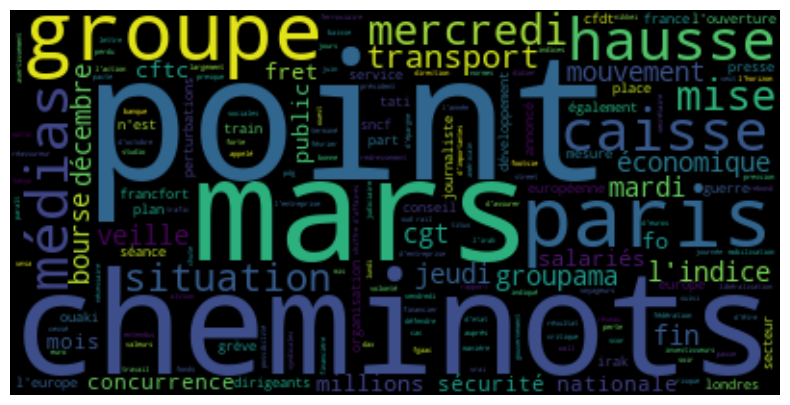

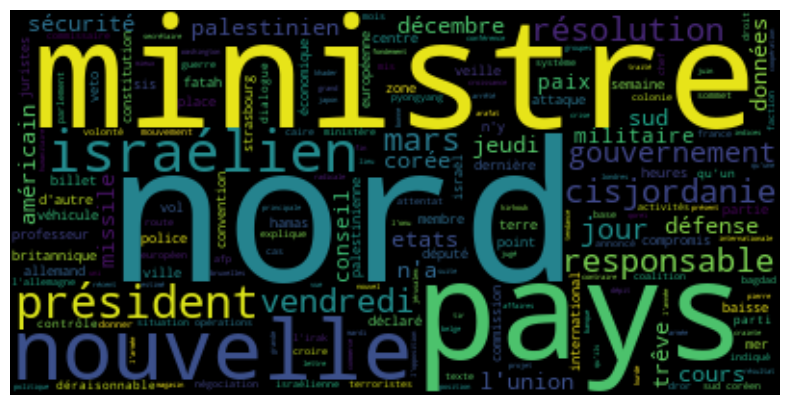

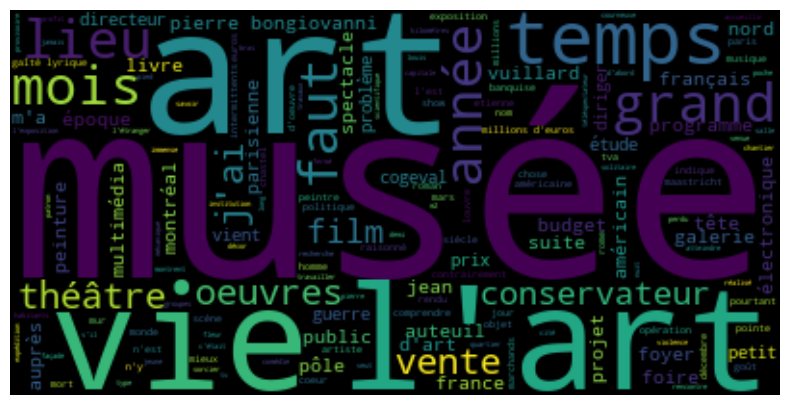

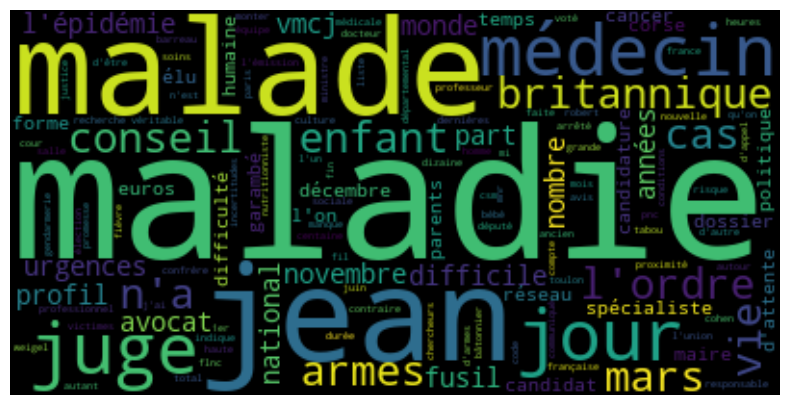

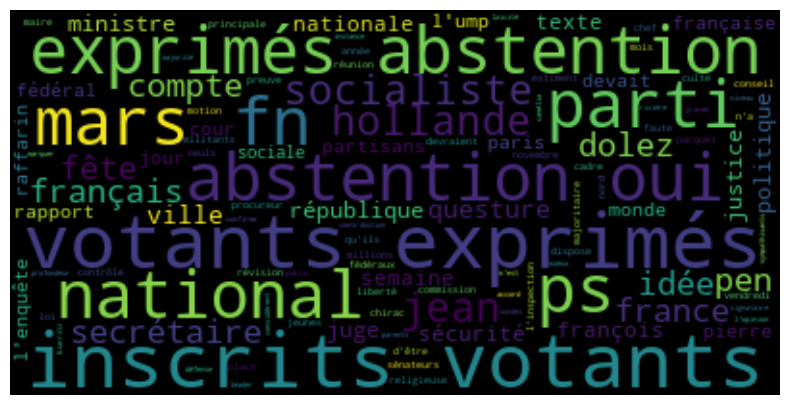

In [31]:
# Display one wordcloud for each of the most frequent classes
STOPWORDS = [x.strip() for x in open('data/stop_word_fr.txt').readlines()]

# plot a word cloud for each category
for cat in ['ENT', 'INT',  'ART', 'SOC', 'FRA']:
    data_cat = data[data['category'] == cat]
    text = str(data_cat['text'])
    wordcloud = WordCloud(repeat=True, stopwords = STOPWORDS).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Bag-of-word representation

In order to apply machine learning algorithms to text, documents must be transformed into vectors. The most simple and standard way to transform a document into a vector is the *bag-of-word* encoding.

The idea is very simple : 

1. define the set of all the possible words that can appear in a document; denote its size by `max_features`.
2. for each document,  encode it with a vector of size `max_features`, with the value of the ith component of the vector equal to the number of time the ith word appears in the document.

See [the wikipedia article on Bag-of-word](https://en.wikipedia.org/wiki/Bag-of-words_model) for an example.

Scikit-learn proposes different methods to encode text into vectors : [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and [TfidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

The encoder must first be trained on the train set and applied to the different sets, for example with the 200  words : 

	from sklearn.feature_extraction.text import CountVectorizer
	vectorizer = CountVectorizer(max_features=200)
    vectorizer.fit(X_train)
    X_train_counts = vectorizer.transform(X_train)
    X_test_counts = vectorizer.transform(X_test)
        
**Question**:

> * Split the dataset LeMonde2003 into train set (80%), dev set (10%)  and test set (10%) using scikit-learn [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
> * For each set, transform the text of the articles into vectors using the `CountVectorizer`, considering the 1000 most frequent words. 
> * Train a naive bayes classifier on the data. 
> * Evaluate the classification accuracy on the train, dev and test sets using the [score](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.score) method. 

> ***Important*** : the test set must not be used during the training phase, and learning the vector representation of the words is part of the training. The dev set should be an evaluation of the test set.



In [35]:
# Splitting the dataset, create X (features) and y (target), print the size
data_train, data_dev_test = train_test_split(data,test_size=0.2, random_state=42)
data_dev, data_test = train_test_split(data_dev_test ,test_size=0.5, random_state=42)

print ('train size',data_train.shape)
print ('dev size', data_dev.shape)
print ('test size', data_test.shape)

train size (24132, 2)
dev size (3016, 2)
test size (3017, 2)


In [36]:
# Creating features X and target y
X_train = data_train.text
X_dev = data_dev.text
X_test = data_test.text
y_train = data_train.category
y_dev = data_dev.category
y_test = data_test.category

In [38]:
# Creating document vectors

document = data.text
# creating the vectorizer object
vectorizer = CountVectorizer(max_features=1000)
# fitting on train data
vectorizer.fit(X_train)
# applying it on train and dev data
X_train_counts = vectorizer.transform(X_train)
X_dev_counts = vectorizer.transform(X_dev)
X_test_counts = vectorizer.transform(X_test)

In [39]:
vectorizer

CountVectorizer(max_features=1000)

In [41]:
X_train_counts.shape

(24132, 1000)

In [43]:
# Training a Naive Bayes classifier
# Creating the MultinomialNB
classifier = MultinomialNB()
# Train 
classifier.fit(X_train_counts, y_train)

# Evaluate 
y_pred = classifier.predict(X_test_counts)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)


Accuracy: 0.7305270135896585
F1 Score: 0.7357115876740887


## TF-IDF representation

The `CountVectorizer` encodes the text using the raw frequencies of the words. However, words that are very frequent and appear in all the documents will have a strong weight whereas they are not discriminative. The *Term-Frequency Inverse-Document-Frequency* weighting scheme take into accound the number of documents in which a given word occurs. A word that appear in many document will have less weight. See [the wikipedia page](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) for more details.

With scikit-learn, the `TfidfTransformer` is applied after the `CountVectorizer` :

	from sklearn.feature_extraction.text import TfidfTransformer
	tf_transformer = TfidfTransformer().fit(X_train_counts)
 	X_train_tf = tf_transformer.transform(X_train_counts)
	X_test_tf = tf_transformer.transform(X_test_counts)
	
**Question**:

> * Use the TF-IDF representation to train a Multinomial Naive Bayes classifier. Report your best test error rate and the error rates for all the configurations tested.

In [45]:
tf_transformer = TfidfTransformer().fit(X_train_counts)

X_train_tf = tf_transformer.transform(X_train_counts)
X_test_tf = tf_transformer.transform(X_test_counts)
X_dev_tf = tf_transformer.transform(X_dev_counts)

# Creating the MultinomialNB
classifier_tf = MultinomialNB()

# Train 
classifier_tf.fit(X_train_tf, y_train)

# Evaluate
y_pred_tf = classifier_tf.predict(X_test_tf)
accuracy_tf = accuracy_score(y_pred_tf, y_test)
f1_tf = f1_score(y_pred_tf, y_test, average="weighted")

print("Accuracy:", accuracy_tf)
print("F1 Score:", f1_tf)

Accuracy: 0.7457739476300961
F1 Score: 0.7737379630853914


## Error analysis

The classification error rate give an evaluation of the performance for all the classes. But since the classes are not equally distributed, they may not be equally well modelized. In order to get a better idea of the performance of the classifier, detailed metrics must be used : 

* [metrics.classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) provides a detailed analysis per class : the precision (amongst all the example classified as class X, how many are really from the classX) and the recall (amongst all the example that are from the class X, how many are classified as class X) and the F-Score which is as a weighted harmonic mean of the precision and recall.
* [metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) which give the confusions between the classes. It can be displayed in color with [plot_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix).

**Question**:

> * Report the `classification_report` for your  classifier. Which classes have the best scores ? Why ?
> * Report the `confusion_matrix` for your  classifier. Which classes are the most confused ? Why ?


              precision    recall  f1-score   support

         ART       0.75      0.86      0.80       466
         ENT       0.75      0.86      0.80       598
         FRA       0.66      0.65      0.66       357
         INT       0.75      0.89      0.81       750
         SOC       0.68      0.61      0.64       364
         SPO       0.95      0.75      0.84       278
         UNE       0.00      0.00      0.00       204

    accuracy                           0.75      3017
   macro avg       0.65      0.66      0.65      3017
weighted avg       0.70      0.75      0.72      3017

[[402  24  10  19   9   1   1]
 [ 14 512  13  47  10   2   0]
 [ 13  33 233  30  47   1   0]
 [ 13  33  15 671  18   0   0]
 [ 34  27  47  32 223   1   0]
 [ 12  27   3  19   8 209   0]
 [ 47  23  32  81  14   7   0]]


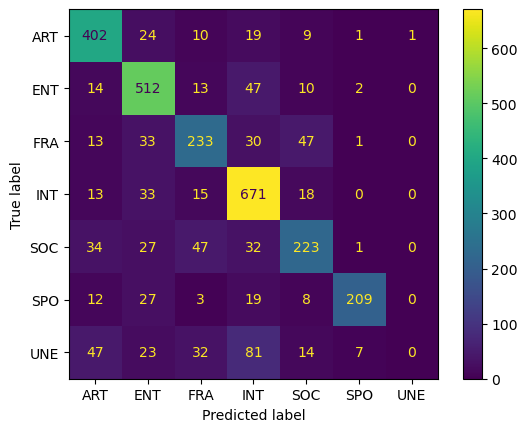

In [50]:
print(classification_report(y_test, y_pred_tf))
print(confusion_matrix(y_test, y_pred_tf))

# prettier
conf_matrix = ConfusionMatrixDisplay.from_estimator(classifier_tf, X_dev_tf, y_dev)

## Data re-configuration
After the error analysis, we came to the conclusion that one of the class can not be distinguised from the others. There is no use trying to solve an impossible problem.

**Questions**:

> * Remove the class `UNE` from the original dataset and merge the semantically close classes 'FRANCE' and 'SOCIETE'
> * Plot the class statitics with seaborn
> * Create new splits
> * Retrain a NaiveBayes classifier using [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) with the 1000 most frequent words.

In [71]:
# Filtering out the 'UNE' category
data2 = data[data['category'] != 'UNE'].copy()

# Merging 'FRANCE' and 'SOCIETY'
data2['category'] = data2['category'].replace({'FRA': 'FR_SOC', 'SOC': 'FR_SOC'})

category
FR_SOC    7371
INT       7328
ENT       6251
ART       4552
SPO       2608
Name: count, dtype: int64
object


count      28110
unique         5
top       FR_SOC
freq        7371
Name: category, dtype: object


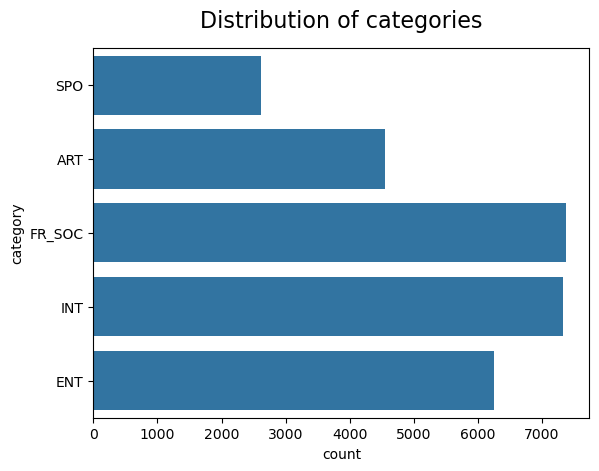

In [73]:
# Plot the statistics of classes
sns.countplot(data = data2, y='category').set_title("Distribution of categories", fontsize=16, pad=15)
print(data2['category'].describe())

In [74]:
# Making the splits and printing the sizes for checking
data2_train, data2_dev_test = train_test_split(data2,test_size=0.2, random_state=42)
data2_dev, data2_test = train_test_split(data2_dev_test ,test_size=0.5, random_state=42)

print ('train size',data2_train.shape)
print ('dev size', data2_dev.shape)
print ('test size', data2_test.shape)

train size (22488, 2)
dev size (2811, 2)
test size (2811, 2)


In [75]:
X_train2 = data2_train.text
X_dev2 = data2_dev.text
X_test2 = data2_test.text
y_train2 = data2_train.category
y_dev2 = data2_dev.category
y_test2 = data2_test.category

Accuracy: 0.8345784418356457
F1 Score: 0.8345927407777171


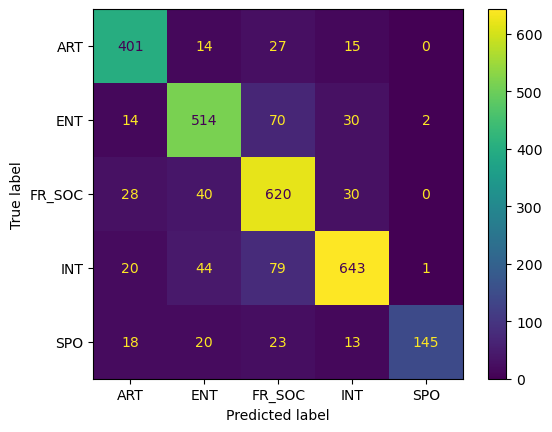

In [80]:
# Applying TfidfVectorizer
tf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfv = tf_vectorizer.fit_transform(X_train2)
X_dev_tfv = tf_vectorizer.transform(X_dev2)
X_test_tfv = tf_vectorizer.transform(X_test2)

# Train MultinomialNB
classifier_tfv = MultinomialNB()
classifier_tfv.fit(X_train_tfv, y_train2)

# Print accuracy
y_pred_tfv = classifier_tfv.predict(X_test_tfv)
accuracy_tfv = accuracy_score(y_pred_tfv, y_test2)
f1_tfv = f1_score(y_pred_tfv, y_test2, average="weighted")

print("Accuracy:", accuracy_tfv)
print("F1 Score:", f1_tfv)

# Print confusion matrix
conf_matrix2 = ConfusionMatrixDisplay.from_estimator(classifier_tfv, X_dev_tfv, y_dev2)

## What about the LLMs?

**You must write the answer to this question in a notebook hosted in your github account and give access to your supervisor.**

LLMs are reputed to have revolutionised automatic language processing. Since the introduction of BERT-type models, all language processing applications have been based on LLMs, of varying degrees of sophistication and size. These models are trained on multiple tasks and are therefore capable of performing new tasks without learning, simply from a prompt. This is known as "zero-shot learning" because there is no learning phase as such. We are going to test these models on our classification task.

Huggingface is a Franco-American company that develops tools for building applications based on Deep Learning. In particular, it hosts the huggingface.co portal, which contains numerous Deep Learning models. These models can be used very easily thanks to the [Transformer] library (https://huggingface.co/docs/transformers/quicktour) developed by HuggingFace.

Using a transform model in zero-shot learning with HuggingFace is very simple: [see documentation](https://huggingface.co/tasks/zero-shot-classification)

However, you need to choose a suitable model from the list of models compatible with Zero-Shot classification. HuggingFace offers [numerous models](https://huggingface.co/models?pipeline_tag=zero-shot-classification). 

The classes proposed to the model must also provide sufficient semantic information for the model to understand them.

**Question**:

* Write a code to classify an example of text from an article in Le Monde using a model transformed using zero-sot learning with the HuggingFace library.
* choose a model and explain your choice
* choose a formulation for the classes to be predicted
* show that the model predicts a class for the text of the article (correct or incorrect, analyse the results)
* evaluate the performance of your model on 100 articles (a test set).
* note model sizes, processing times and classification results


Notes :
* make sure that you use the correct Tokenizer when using a model 
* start testing with a small number of articles and the first 100's of characters for faster experiments.